In [1]:
# import libraries
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import seaborn as sns
import copy, time, matplotlib, sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
from torchsummary import summary

import torchvision
import torchvision.transforms as T

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
# plt.rcParams.update({'font.size':11})

In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# FFNs (Feed-Forward Networks)

In [ ]:
''' What are fully-connected and feedforward networks?
* Fully connected network
- Terminology: "Fully connected" means that each node in layer n projects to each node in layer n+1.
  Each connection has its own weight.
- Terminology: "Fully connected" is really short-hand for "Fully feedforward connected."
- Terminology: "Feedforward" means that the activation propagates from input to output.
  But all learning networks also have backprop...
'''

# The MNIST dataset

In [ ]:
# import dataset
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

# shape of the data matrix
data.shape

(20000, 785)

In [ ]:
# extract labels (number IDs) and remove from data
labels = data[:,0]
data = data[:,1:]

print(labels.shape)
print(data.shape)

(20000,)
(20000, 784)


In [ ]:
labels

array([6., 5., 7., ..., 2., 9., 5.])

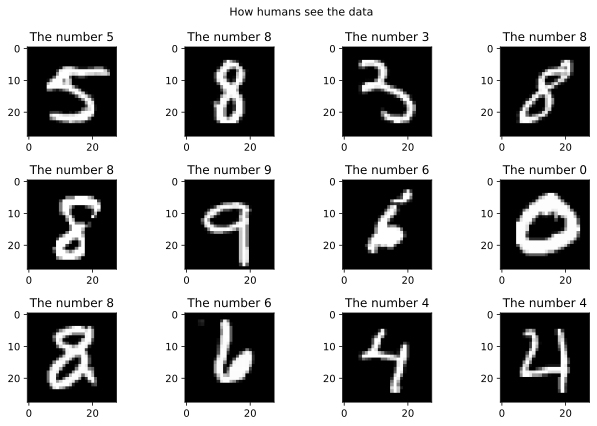

In [ ]:
# show a few random digits
fig, axs = plt.subplots(3,4,figsize=(9,6))

for ax in axs.flatten():
    # pick a random image
    randimg2show = np.random.randint(0, high=data.shape[0])

    # create the image (must be reshaped!)
    img = np.reshape(data[randimg2show, :], (28,28))
    ax.imshow(img, cmap='gray')

    # title
    ax.set_title('The number %i' %labels[randimg2show])

plt.suptitle('How humans see the data', fontsize=11)
# plt.tight_layout(rect=[0,0,1,.95])
plt.tight_layout()
plt.show()

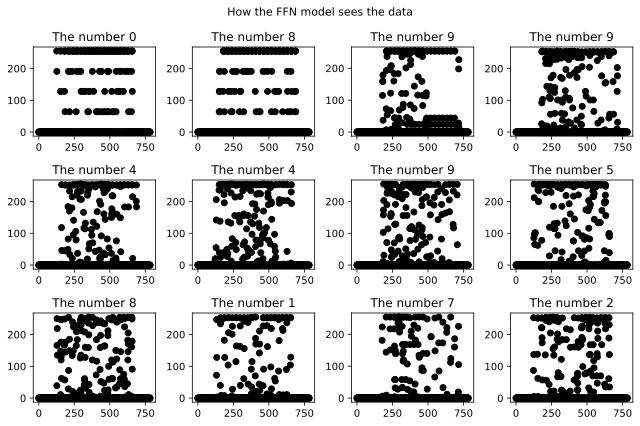

In [ ]:
# show a few random digits
fig, axs = plt.subplots(3,4,figsize=(9,6))

for ax in axs.flatten():
    randimg2show = np.random.randint(0, high=data.shape[0])
    ax.plot(data[randimg2show, :], 'ko')
    ax.set_title('The number %i' % labels[randimg2show])

plt.suptitle('How the FFN model sees the data', fontsize=11)
plt.tight_layout()
plt.show()

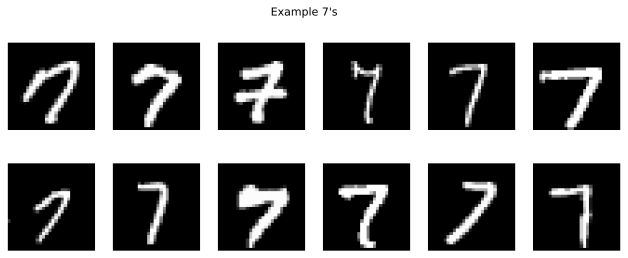

In [ ]:
# let's see some example 7s

# find indices of all the 7's in the dataset
the7s = np.where(labels==7)[0]

# draw the first 12
fig, axs = plt.subplots(2,6,figsize=(11,4))

for i, ax in enumerate(axs.flatten()):
    img = np.reshape(data[the7s[i],:], (28,28))
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.suptitle("Example 7's", fontsize=11)
# plt.tight_layout()
plt.show()

In [ ]:
# how similar are all the 7's?

# how many 7's are there?
print(data[the7s,:].shape)

(2126, 784)


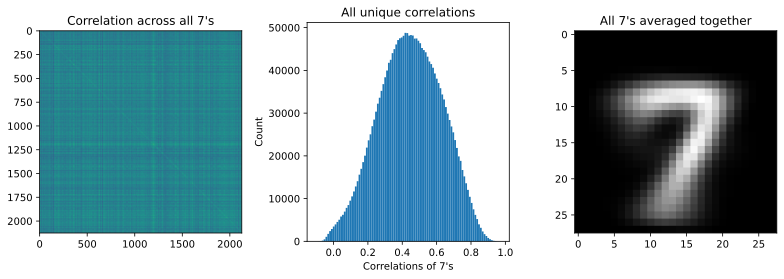

In [ ]:
# let's see how they relate to each other by computing spatial correlations
C = np.corrcoef(data[the7s,:])

# and visualize
fig, ax = plt.subplots(1,3,figsize=(11,4))
ax[0].imshow(C, vmin=0, vmax=1)
ax[0].set_title("Correlation across all 7's")

# extract the unique correlations and show as a scatterplot
uniqueCs = np.triu(C, k=1).flatten()
ax[1].hist(uniqueCs[uniqueCs!=0], bins=100)
ax[1].set_title('All unique correlations')
ax[1].set_xlabel("Correlations of 7's")
ax[1].set_ylabel('Count')

# show all 7's together
aveAll7s = np.reshape( np.mean(data[the7s,:], axis=0), (28,28) )
ax[2].imshow(aveAll7s, cmap='gray')
ax[2].set_title("All 7's averaged together")

plt.tight_layout()
plt.show()

# FFN to classify digits

In [ ]:
''' Softmax vs. log-softmax
- Log-softmax "stretches" out the penalties for incorrect guesses, which can improve category separability
  and increase numerical stability.
- Lin-softmax works fine on problems with a "small number" of categories, or when categories are easily differentiable.
- As with many DL parameters, try both; don't asume that one will always work better.
'''

## Import and process the data

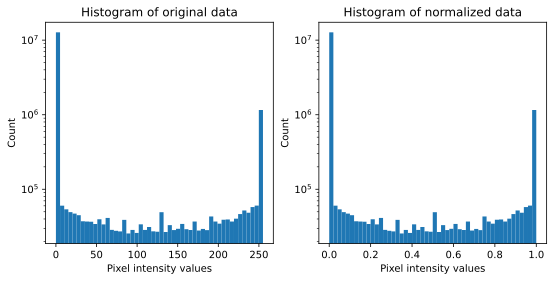

In [ ]:
# import dataset
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

fig, ax = plt.subplots(1,2,figsize=(9,4))
ax[0].hist(data.flatten(), 50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')
ax[0].set_yscale('log')

ax[1].hist(dataNorm.flatten(), 50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')
ax[1].set_yscale('log')

plt.show()

## Create train/test groups using DataLoader

In [ ]:
# Step 1 : convert to tensor
data_tensor = torch.tensor(dataNorm).float()
labels_tensor = torch.tensor(labels).long() # long = int64

# Step 2 : split the data
train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.1)

# Step 3 : convert into PyTorch Datasets
trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

# Step 4 : translate into dataloader objects
batchsize=32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

In [ ]:
# check all variables in workspace
%whos

Variable            Type             Data/Info
----------------------------------------------
C                   ndarray          2126x2126: 4519876 elems, type `float64`, 36159008 bytes (34.483917236328125 Mb)
DataLoader          type             <class 'torch.utils.data.dataloader.DataLoader'>
Dataset             type             <class 'torch.utils.data.dataset.Dataset'>
F                   module           <module 'torch.nn.functio<...>/torch/nn/functional.py'>
PCA                 ABCMeta          <class 'sklearn.decomposition._pca.PCA'>
Subset              type             <class 'torch.utils.data.dataset.Subset'>
T                   module           <module 'torchvision.tran<...>/transforms/__init__.py'>
TensorDataset       type             <class 'torch.utils.data.dataset.TensorDataset'>
aveAll7s            ndarray          28x28: 784 elems, type `float64`, 6272 bytes
ax                  ndarray          2: 2 elems, type `object`, 16 bytes
axs                 ndarray          2

## Create the DL model

In [ ]:
def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            self.input = nn.Linear(784, 64)
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)
            self.output = nn.Linear(32,10)

        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return torch.log_softmax( self.output(x), axis=1 )
            # log-softmax the output, because I'm using NLLoss instead of CrossEntropyLoss

    net = mnistNet()
    lossfunc = nn.NLLLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=.01)

    return net, lossfunc, optimizer

In [ ]:
# test the model with one batch
net, lossfunc, optimizer = createTheMNISTNet()

X, y = next(iter(train_loader))
yHat = net(X)

# values are log-probability of each number (0-9)
print(yHat)

# now let's compute the loss
loss = lossfunc(yHat, y)
print()
print('Loss:')
print(loss)

## Create a function that trains the model

In [ ]:
def function2trainTheModel():

    numepochs = 60

    net, lossfunc, optimizer = createTheMNISTNet()

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):

        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            yHat = net(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

        trainAcc.append( np.mean(batchAcc) )
        losses[epochi] = np.mean(batchLoss)

        X, y = next(iter(test_loader))
        yHat = net(X)

        testAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

    return trainAcc, testAcc, losses, net

## Run the model and show the results!

In [ ]:
trainAcc, testAcc, losses, net = function2trainTheModel()

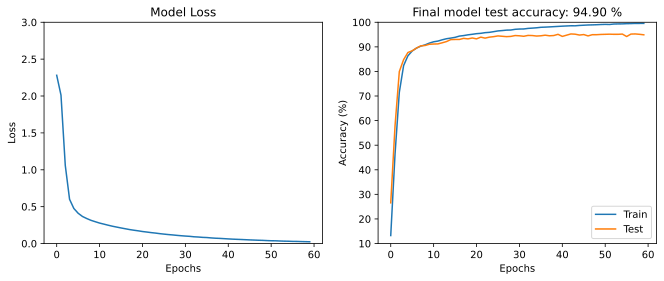

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model Loss')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f} %')
ax[1].legend()

plt.show()

## Inspect the results in more detail

In [ ]:
# run the model through for the test data
X, y = next(iter(test_loader))
predictions = net(X).detach()

predictions

tensor([[-1.7420e+01, -1.8559e+01, -2.9607e+01,  ..., -1.9298e+01,
         -1.2991e+01, -1.2561e+01],
        [-1.2859e+01, -1.7221e+01, -1.3231e+01,  ..., -2.1692e+01,
         -2.0556e+01, -2.7621e+01],
        [-1.1660e+01, -1.7168e+01, -1.6790e+01,  ..., -6.2724e+00,
         -6.5011e+00, -3.4443e-03],
        ...,
        [-1.2549e+01, -2.3679e+00, -3.2367e+00,  ..., -1.2223e+01,
         -1.2422e+01, -2.7137e+01],
        [-2.7736e+01, -1.2447e+01, -1.0298e+01,  ..., -4.2080e-05,
         -1.8968e+01, -2.1527e+01],
        [-1.7435e+01, -1.6487e+01, -2.1535e+01,  ..., -1.8885e+01,
         -7.1362e+00, -1.1539e+01]])

In [ ]:
torch.exp(predictions)

tensor([[2.7210e-08, 8.7081e-09, 1.3869e-13,  ..., 4.1594e-09, 2.2813e-06,
         3.5065e-06],
        [2.6014e-06, 3.3198e-08, 1.7933e-06,  ..., 3.7954e-10, 1.1818e-09,
         1.0098e-12],
        [8.6343e-06, 3.4991e-08, 5.1052e-08,  ..., 1.8877e-03, 1.5018e-03,
         9.9656e-01],
        ...,
        [3.5489e-06, 9.3674e-02, 3.9291e-02,  ..., 4.9156e-06, 4.0287e-06,
         1.6382e-12],
        [9.0018e-13, 3.9296e-06, 3.3688e-05,  ..., 9.9996e-01, 5.7862e-09,
         4.4780e-10],
        [2.6809e-08, 6.9172e-08, 4.4429e-10,  ..., 6.2849e-09, 7.9581e-04,
         9.7435e-06]])

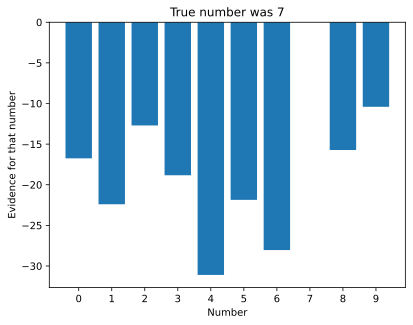

In [ ]:
# Evidence for all numbers from one sample
sample2show = 120

plt.bar(range(10), predictions[sample2show]) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' % y[sample2show].item())
plt.show()

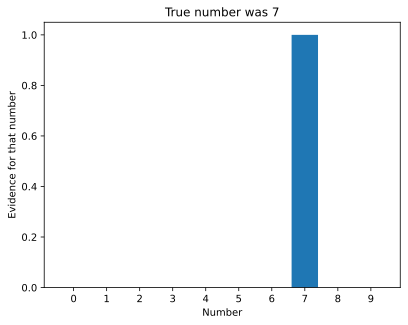

In [ ]:
plt.bar(range(10), torch.exp(predictions[sample2show])) # try adding exp!
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' % y[sample2show].item())
plt.show()

In [ ]:
# find the errors
errors = np.where( torch.max(predictions, axis=1)[1] != y)[0]
print(errors)

[  13   20   47   78  123  151  183  190  211  225  230  240  273  347
  378  380  397  402  421  422  472  495  521  539  549  558  576  609
  625  653  665  674  678  685  699  706  712  741  750  798  808  814
  815  824  852  862  885  887  892  901  904  912  929  930  951  959
 1009 1062 1112 1131 1143 1217 1237 1285 1303 1310 1361 1362 1372 1383
 1395 1405 1421 1428 1476 1484 1512 1538 1548 1555 1561 1563 1564 1588
 1615 1625 1657 1667 1670 1674 1678 1692 1697 1757 1759 1771 1799 1839
 1856 1882 1901 1934]


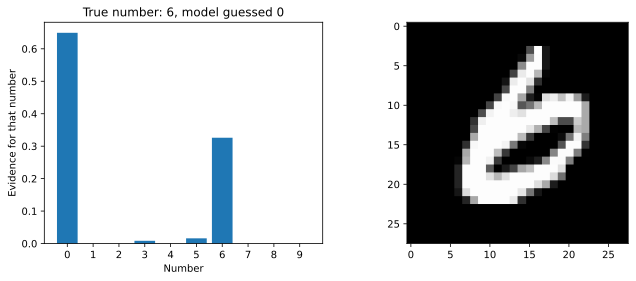

In [ ]:
# Evidence for all numbers from one sample
sample2show = 4

fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].bar(range(10), np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s'
                % ( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item()))

ax[1].imshow( np.reshape(X[errors[sample2show],:], (28,28)), cmap='gray')

plt.show()

# Binarized MNIST images

## The data

In [ ]:
# import dataset
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

labels = data[:,0]
data = data[:, 1:]

# normalize the data to 0 or 1
dataNorm = (data > 0).astype(float)

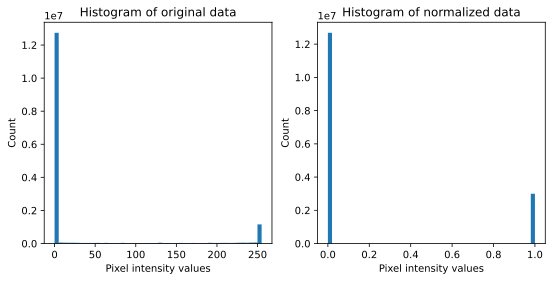

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(9,4))

ax[0].hist(data.flatten(), 50)
ax[0].set_xlabel('Pixel intensity values')
ax[0].set_ylabel('Count')
ax[0].set_title('Histogram of original data')

ax[1].hist(dataNorm.flatten(), 50)
ax[1].set_xlabel('Pixel intensity values')
ax[1].set_ylabel('Count')
ax[1].set_title('Histogram of normalized data')

plt.show()

In [ ]:
# confirm that the data have limited values
print(np.unique(data))
print()
print(np.unique(dataNorm))

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195.
 196. 

## Create train/test groups using DataLoader

In [ ]:
data_tensor = torch.tensor(dataNorm).float()
labels_tensor = torch.tensor(labels).long()

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.1)

trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

batchsize = 32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

## Create the DL model

In [ ]:
def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            self.input = nn.Linear(784, 64)
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)
            self.output = nn.Linear(32,10)

        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return torch.log_softmax(self.output(x), axis=1)

    net = mnistNet()
    lossfunc = nn.NLLLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=.01)

    return net, lossfunc, optimizer

In [ ]:
# test the model with one batch
net, lossfunc, optimizer = createTheMNISTNet()

X, y = next(iter(train_loader))
yHat = net(X)

print(yHat.shape)
torch.unique(X)

torch.Size([32, 10])


tensor([0., 1.])

## Create a function that trains the model

In [ ]:
def function2trainTheModel():

    numepochs = 60

    net, lossfunc, optimizer = createTheMNISTNet()

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):

        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            yHat = net(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

        trainAcc.append( np.mean(batchAcc) )
        losses[epochi] = np.mean(batchLoss)

        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        testAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

    return trainAcc, testAcc, losses, net

## Run the model and show the results!

In [ ]:
trainAcc, testAcc, losses, net = function2trainTheModel()

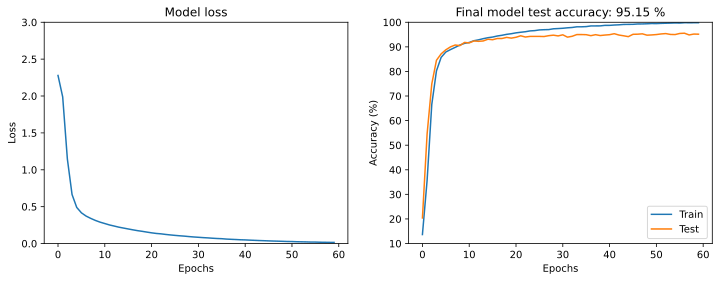

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f} %')
ax[1].set_ylim([10,100])
ax[1].legend()

plt.show()

## Imspect the results in more detail

In [ ]:
# run the model through the test data
X, y = next(iter(test_loader))
predictions = net(X).detach()

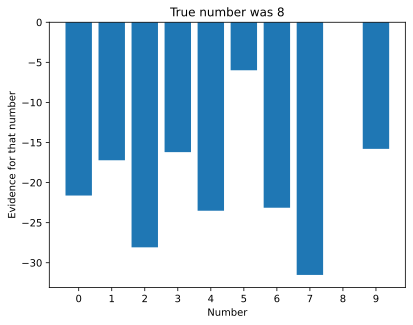

In [ ]:
# Evidence for all numbers from one sample
sample2show = 120

plt.bar(range(10), predictions[sample2show])
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' % y[sample2show].item())
plt.show()

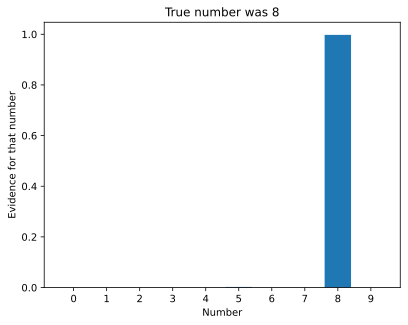

In [ ]:
plt.bar(range(10), torch.exp(predictions[sample2show]))
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.title('True number was %s' % y[sample2show].item())
plt.show()

In [ ]:
# find the errors
errors = np.where( torch.max(predictions, axis=1)[1] != y)[0]
print(errors)

[   9   27   44   95  143  152  156  179  208  246  247  293  299  302
  303  339  362  394  459  472  491  513  518  542  553  583  621  651
  671  698  701  722  745  749  755  776  795  847  874  878  892  900
  904  920  925  930  981  989  994 1002 1010 1018 1028 1036 1058 1088
 1139 1145 1161 1208 1220 1245 1252 1295 1307 1384 1406 1506 1533 1582
 1588 1608 1620 1627 1633 1662 1667 1702 1709 1722 1724 1739 1747 1749
 1753 1757 1777 1813 1814 1829 1840 1877 1882 1910 1924 1946 1967]


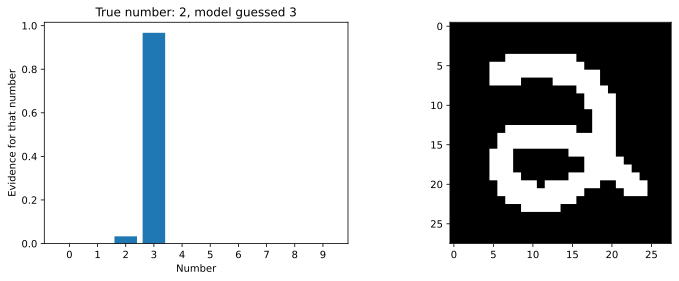

In [ ]:
# Evidence for all numbers from one sample
sample2show = 14

fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].bar(range(10), np.exp(predictions[errors[sample2show]]))
ax[0].set_xticks(range(10))
ax[0].set_xlabel('Number')
ax[0].set_ylabel('Evidence for that number')
ax[0].set_title('True number: %s, model guessed %s'
                %( y[errors[sample2show]].item(), torch.argmax(predictions[errors[sample2show]]).item() ))

ax[1].imshow( np.reshape(X[errors[sample2show],:], (28,28)), cmap='gray' )

plt.show()

# Data normalization

## The data

In [ ]:
# import dataset
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

labels = data[:,0]
data = data[:, 1:]

## Create train/test groups using DataLoader

In [ ]:
data_tensor = torch.tensor(data).float()
labels_tensor = torch.tensor(labels).long()

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.1)

# 0) normalize train to [0 1] and test to [0 1]
# 1) normalize train to [0 1] and test to [0 255]
# 2) normalize train to [0 255] and test to [0 1]

# train_data = train_data / torch.max(train_data)
test_data = test_data / torch.max(test_data)

trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

batchsize=32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

In [ ]:
# confirm ranges of train and test data

print('Training data range %g to %g'
      % (torch.min(train_loader.dataset.tensors[0]), torch.max(train_loader.dataset.tensors[0])))

print('Test data range %g to %g'
      % (torch.min(test_loader.dataset.tensors[0]), torch.max(test_loader.dataset.tensors[0])))

Training data range 0 to 1
Test data range 0 to 1


In [ ]:
print('Training data range %g to %g'
      % (torch.min(train_loader.dataset.tensors[0]), torch.max(train_loader.dataset.tensors[0])))

print('Test data range %g to %g'
      % (torch.min(test_loader.dataset.tensors[0]), torch.max(test_loader.dataset.tensors[0])))

Training data range 0 to 1
Test data range 0 to 255


In [ ]:
print('Training data range %g to %g'
      % (torch.min(train_loader.dataset.tensors[0]), torch.max(train_loader.dataset.tensors[0])))

print('Test data range %g to %g'
      % (torch.min(test_loader.dataset.tensors[0]), torch.max(test_loader.dataset.tensors[0])))

Training data range 0 to 255
Test data range 0 to 1


## Create the DL model

In [ ]:
def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            self.input = nn.Linear(784, 64)
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)
            self.output = nn.Linear(32,10)

        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return self.output(x)

    net = mnistNet()
    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=.01)

    return net, lossfunc, optimizer

## Create a function that trains the model

In [ ]:
def function2trainTheModel():

    numepochs = 60

    net, lossfunc, optimizer = createTheMNISTNet()

    losses = torch.zeros((numepochs,2))
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):

        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            yHat = net(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

        trainAcc.append(np.mean(batchAcc))

        losses[epochi, 0] = np.mean(batchLoss)

        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        testAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )
        loss = lossfunc(yHat, y)
        losses[epochi, 1] = loss.item()

    return trainAcc, testAcc, losses, net

## Run the model and show the results!

In [ ]:
trainAcc, testAcc, losses, net = function2trainTheModel()

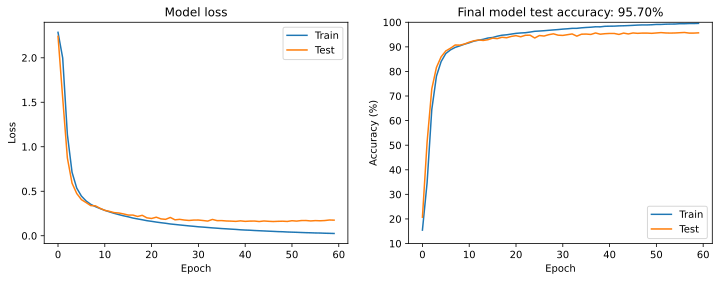

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(losses)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(['Train', 'Test'])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

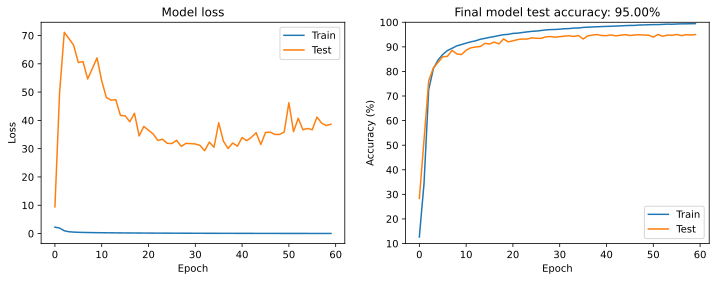

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(losses)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(['Train', 'Test'])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

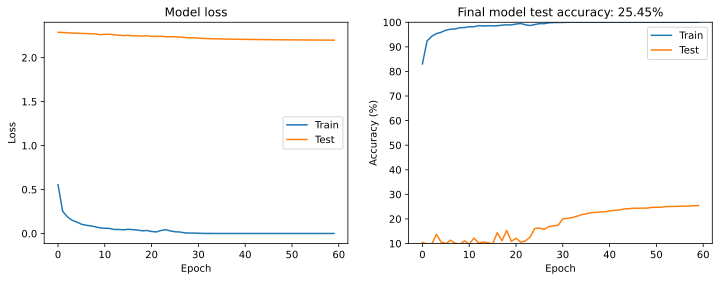

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(losses)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(['Train', 'Test'])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [ ]:
''' Discussion: Loss vs. accuracy
- Losses are scale-dependent.
- Accuracy is boolean (0/1).
- DL models find patterns in the data; numerical range may not be important.
- Take-home point: Losses show whether the model is still learning; accuracy is the metric you really care about.
'''

In [ ]:
''' Take-home messages
- Always normalize your data.
- Normalize train and test data using the same normalization factors.
- Normalization also helps prevent overflow and underflow (numerical inaccuracies) in weights and gradients.
- Some datasets and models may perform well without normalization, don't assume they will! Just normalize!
'''

# Distributions of weights pre- and post- learning

In [ ]:
''' Weight initialization and changes
- Remember: The entire purpose of DL is to set the weights: argmin(cost)
- Weights are initialized as random numbers and adjusted during learning.
- How does learning affect the distributions of the weights?
'''

## The data

In [ ]:
# import dataset
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

## Create train/test groups using DataLoader

In [ ]:
data_tensor = torch.tensor(dataNorm).float()
labels_tensor = torch.tensor(labels).long()

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.1)

trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

batchsize=32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

## Create the DL model

In [ ]:
def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            self.input = nn.Linear(784, 64)
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)
            self.output = nn.Linear(32,10)

        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return self.output(x)

    net = mnistNet()
    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=.01)

    return net, lossfunc, optimizer

In [ ]:
# exploring the "innards" of the model

net = createTheMNISTNet()[0]

# summary of the entire model
print('Summary of model:')
print(net)
print()

Summary of model:
mnistNet(
  (input): Linear(in_features=784, out_features=64, bias=True)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=10, bias=True)
)



In [ ]:
# explore one of the layers
print('Summary of input layer:')
print(vars(net.input))

Summary of input layer:
{'training': True, '_parameters': OrderedDict([('weight', Parameter containing:
tensor([[ 7.4083e-03, -2.3579e-02,  2.1837e-02,  ...,  1.0763e-02,
          1.3743e-02, -6.1761e-03],
        [ 2.5610e-02, -8.1238e-03, -2.8888e-02,  ...,  8.8947e-05,
         -1.9404e-02,  1.8405e-02],
        [-2.1078e-03,  1.0506e-03, -1.7504e-02,  ..., -2.5220e-02,
          5.8164e-03, -2.2268e-02],
        ...,
        [ 2.1511e-02, -1.3549e-02, -4.7553e-03,  ...,  4.9858e-03,
          6.7670e-03, -2.0224e-02],
        [-1.4948e-02,  1.0718e-02, -1.0807e-02,  ..., -1.7877e-02,
         -6.0566e-03, -2.6172e-02],
        [-2.3060e-02, -3.0779e-02, -9.4025e-03,  ...,  1.4128e-02,
          2.1767e-02, -6.0402e-03]], requires_grad=True)), ('bias', Parameter containing:
tensor([-0.0023, -0.0044, -0.0290, -0.0272, -0.0003,  0.0220, -0.0288,  0.0154,
         0.0131, -0.0095,  0.0340, -0.0315, -0.0093, -0.0244,  0.0225,  0.0060,
         0.0139, -0.0133, -0.0162,  0.0330, -0.0055

In [ ]:
# check out the matrix of weights
print('Input layer weights:')
print(net.input.weight.shape)
print()
print(net.input.weight)

Input layer weights:
torch.Size([64, 784])

Parameter containing:
tensor([[ 7.4083e-03, -2.3579e-02,  2.1837e-02,  ...,  1.0763e-02,
          1.3743e-02, -6.1761e-03],
        [ 2.5610e-02, -8.1238e-03, -2.8888e-02,  ...,  8.8947e-05,
         -1.9404e-02,  1.8405e-02],
        [-2.1078e-03,  1.0506e-03, -1.7504e-02,  ..., -2.5220e-02,
          5.8164e-03, -2.2268e-02],
        ...,
        [ 2.1511e-02, -1.3549e-02, -4.7553e-03,  ...,  4.9858e-03,
          6.7670e-03, -2.0224e-02],
        [-1.4948e-02,  1.0718e-02, -1.0807e-02,  ..., -1.7877e-02,
         -6.0566e-03, -2.6172e-02],
        [-2.3060e-02, -3.0779e-02, -9.4025e-03,  ...,  1.4128e-02,
          2.1767e-02, -6.0402e-03]], requires_grad=True)


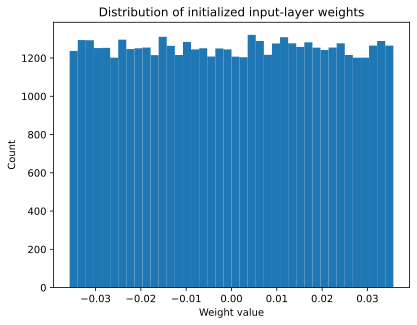

In [ ]:
# finally, extract the weights and make a histogram
w = net.input.weight.detach().flatten()
plt.hist(w, 40)
plt.xlabel('Weight value')
plt.ylabel('Count')
plt.title('Distribution of initialized input-layer weights')
plt.show()

In [ ]:
# a function that returns a histogram of all weights (across all layers)

def weightsHistogram(net):

    # initialize weight vector
    W = np.array([])

    # concatenate each set of weights
    for layer in net.parameters():
        W = np.concatenate(( W, layer.detach().flatten().numpy() ))

    # compute their histogram (note: range is hard-coded)
    histy, histx = np.histogram(W, bins=np.linspace(-.8, .8, 101), density=True)
    histx = (histx[1:]+histx[:-1])/2
    return histx, histy

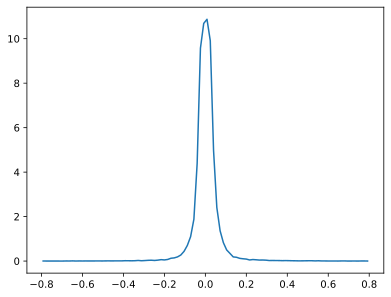

In [ ]:
# test it!
histx, histy = weightsHistogram(net)
plt.plot(histx, histy);

## Create a function that trains the model

In [ ]:
def function2trainTheModel():

    numepochs = 100

    net, lossfunc, optimizer = createTheMNISTNet()

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    # initialize histogram variables
    histx = np.zeros((numepochs, 100))
    histy = np.zeros((numepochs, 100))

    for epochi in range(numepochs):

        # get the weights distribution at the start of this epoch
        histx, histy[epochi, :] = weightsHistogram(net)

        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            yHat = net(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        testAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

    return trainAcc, testAcc, losses, net, histx, histy

## Run the model and show the results!

In [ ]:
trainAcc, testAcc, losses, net, histx, histy = function2trainTheModel()

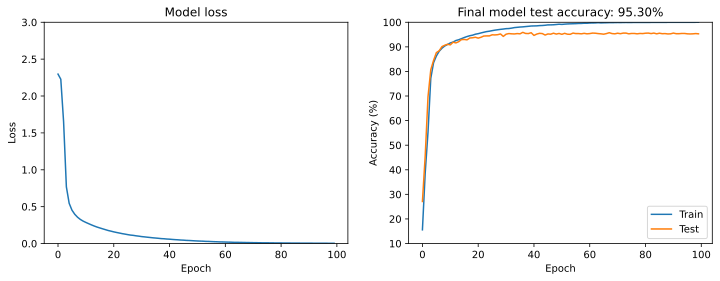

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(losses)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

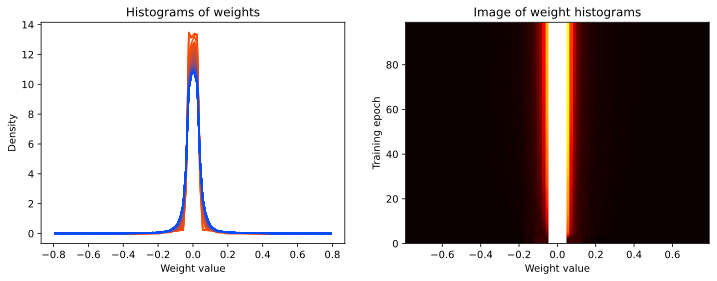

In [ ]:
# show the histogram of the weights

ffig,ax = plt.subplots(1,2,figsize=(12,4))

for i in range(histy.shape[0]):
  ax[0].plot(histx,histy[i,:],color=[1-i/100,.3,i/100])

ax[0].set_title('Histograms of weights')
ax[0].set_xlabel('Weight value')
ax[0].set_ylabel('Density')


ax[1].imshow(histy,vmin=0,vmax=3,
             extent=[histx[0],histx[-1],0,99],aspect='auto',origin='lower',cmap='hot')
ax[1].set_xlabel('Weight value')
ax[1].set_ylabel('Training epoch')
ax[1].set_title('Image of weight histograms')

plt.show()

# MNIST and breadth vs. depth

## Create the DL model

In [ ]:
def createTheMNISTNet(nUnits, nLayers):

    class mnistNet(nn.Module):
        def __init__(self, nUnits, nLayers):
            super().__init__()

            # create dictionary to store the layers
            self.layers = nn.ModuleDict()
            self.nLayers = nLayers

            # input layer
            self.layers['input'] = nn.Linear(784, nUnits)

            # hidden layers
            for i in range(nLayers):
                self.layers[f'hidden{i}'] = nn.Linear(nUnits, nUnits)

            # output layer
            self.layers['output'] = nn.Linear(nUnits, 10)

        def forward(self, x):
            # input layer
            x = F.relu(self.layers['input'](x))

            # hidden layers
            for i in range(self.nLayers):
                x = F.relu(self.layers[f'hidden{i}'](x))

            # return output layer
            x = self.layers['output'](x)
            return x

    net = mnistNet(nUnits, nLayers)
    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=.01)

    return net, lossfunc, optimizer

In [ ]:
# Generate an instance of the model and confirm that it returns the expected network.
nUnitsPerLayer = 12
nLayers = 4
net = createTheMNISTNet(nUnitsPerLayer, nLayers)
net

(mnistNet(
   (layers): ModuleDict(
     (input): Linear(in_features=784, out_features=12, bias=True)
     (hidden0): Linear(in_features=12, out_features=12, bias=True)
     (hidden1): Linear(in_features=12, out_features=12, bias=True)
     (hidden2): Linear(in_features=12, out_features=12, bias=True)
     (hidden3): Linear(in_features=12, out_features=12, bias=True)
     (output): Linear(in_features=12, out_features=10, bias=True)
   )
 ),
 CrossEntropyLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

## Create a function that trains the model

In [ ]:
def function2trainTheModel(nUnits, nLayers):

    numepochs = 60

    net, lossfunc, optimizer = createTheMNISTNet(nUnits, nLayers)

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):

        batchAcc = []
        batchLoss = []
        for X, y in train_loader:
            yHat = net(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)

        testAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

    return trainAcc, testAcc, losses, net

## Run the model and show the results!

In [ ]:
# define the model parameters
numlayers = range(1,4) # number of hidden layers: 1,2,3
numunits = np.arange(50,251, 50) # units per hidden layer: 50,100,150,200,250

# initialize output matrices
accuracies = np.zeros((2, len(numunits), len(numlayers)))

# start the experiment!
for unit_idx in range(len(numunits)):
    for layer_idx in range(len(numlayers)):

        # create and train a fresh model
        trainAcc, testAcc, losses, net = function2trainTheModel(numunits[unit_idx], numlayers[layer_idx])

        # store the results (average of final 5 epochs)
        accuracies[0, unit_idx, layer_idx] = np.mean(trainAcc[-5:])
        accuracies[1, unit_idx, layer_idx] = np.mean(testAcc[-5:])

        # print a friendly status message
        print(f'Finished units {unit_idx+1} / {len(numunits)} and layers {layer_idx+1} / {len(numlayers)}')

Finished units 1 / 5 and layers 1 / 3
Finished units 1 / 5 and layers 2 / 3
Finished units 1 / 5 and layers 3 / 3
Finished units 2 / 5 and layers 1 / 3
Finished units 2 / 5 and layers 2 / 3
Finished units 2 / 5 and layers 3 / 3
Finished units 3 / 5 and layers 1 / 3
Finished units 3 / 5 and layers 2 / 3
Finished units 3 / 5 and layers 3 / 3
Finished units 4 / 5 and layers 1 / 3
Finished units 4 / 5 and layers 2 / 3
Finished units 4 / 5 and layers 3 / 3
Finished units 5 / 5 and layers 1 / 3
Finished units 5 / 5 and layers 2 / 3
Finished units 5 / 5 and layers 3 / 3


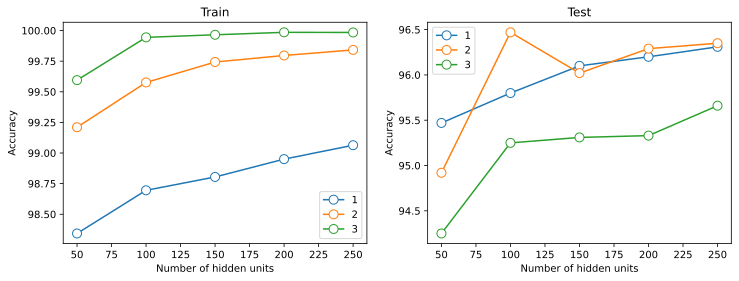

In [ ]:
# show accuracies as a function of model depth
fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].plot(numunits, accuracies[0,:,:], 'o-', markerfacecolor='w', markersize=9)
ax[1].plot(numunits, accuracies[1,:,:], 'o-', markerfacecolor='w', markersize=9)

for i in range(2):
    ax[i].legend(numlayers)
    ax[i].set_ylabel('Accuracy')
    ax[i].set_xlabel('Number of hidden units')
    ax[i].set_title(['Train' if i==0 else 'Test'][0])

plt.show()

In [ ]:
''' Take-home messages
- As with nearly everything in DL, the conclusions of one experiment are not necessarily universal.
- This is why you need to approach DL as an experimental scientist.
- That said: More complex problems generally do better with deeper networks.
  Deep networks can form more abstract representations.
- The iris data is relatively simple, and so multiple layers adds gratuitous complexity and training time.
'''

# Optimizers and MNIST

## Import and process the data

In [2]:
# import dataset
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

## Create train/test groups using DataLoader

In [3]:
# Step 1 : convert to tensor
data_tensor = torch.tensor(dataNorm).float()
labels_tensor = torch.tensor(labels).long() # long = int64

# Step 2 : split the data
train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.1)

# Step 3 : convert into PyTorch Datasets
trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

# Step 4 : translate into dataloader objects
batchsize=32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

## Create the DL model

In [4]:
# create a class for the model
def createTheMNISTNet(optimizerAlgo, learningRate):

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            self.input = nn.Linear(784, 64)
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)
            self.output = nn.Linear(32,10)

        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return self.output(x)

    net = mnistNet()
    lossfunc = nn.CrossEntropyLoss()

    # optimizer
    optifunc = getattr( torch.optim, optimizerAlgo )
    optimizer = optifunc(net.parameters(), lr=learningRate)

    return net, lossfunc, optimizer

## Create a function that trains the model

In [5]:
# a function that trains the model
def function2trainTheModel(optimizerAlgo, learningRate):

    numepochs = 100

    net, lossfunc, optimizer = createTheMNISTNet(optimizerAlgo, learningRate)

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):

        batchAcc = []
        batchLoss = []
        for X, y in train_loader:
            yHat = net(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

        trainAcc.append( np.mean(batchAcc) )
        losses[epochi] = np.mean(batchLoss)

        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        testAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

    return trainAcc, testAcc, losses, net

## Run the model and show the results!

In [7]:
# variables to loop over
learningRates = np.logspace(np.log10(.0001), np.log10(.1), 6)
optimTypes = ['SGD', 'RMSprop', 'Adam']

# initialize performance matrix
finalPerformance = np.zeros((len(learningRates), len(optimTypes)))

# now for the experiment!
for idx_o, opto in enumerate(optimTypes):
    for idx_l, lr in enumerate(learningRates):
        trainAcc, testAcc, losses, net = function2trainTheModel(opto, lr)
        finalPerformance[idx_l, idx_o] = np.mean(testAcc[-10:])

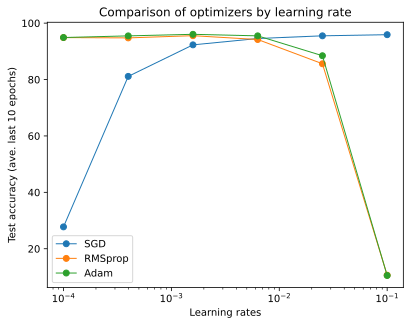

In [9]:
# plot the results!
plt.plot(learningRates, finalPerformance, 'o-', linewidth=1)
plt.legend(optimTypes)
plt.xscale('log')
plt.xlabel('Learning rates')
plt.ylabel('Test accuracy (ave. last 10 epochs)')
plt.title('Comparison of optimizers by learning rate')
plt.show()

# Scrambled MNIST

In [ ]:
''' See whether FFNs leverage spatial information during learning.
- Seen that FFNs do not leverage spatial information during learning.
'''

## Scramble the images

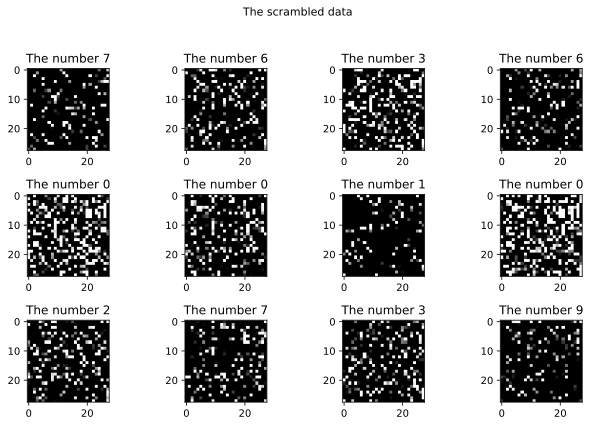

In [10]:
# randomly scramble the data, preserving the re-ordering for each image
eggs = np.random.permutation(data.shape[1])
scrambled = dataNorm[:, eggs]

# show a few random digits
fig, axs = plt.subplots(3,4,figsize=(9,6))

for ax in axs.flatten():
    # pick a random image
    randimg2show = np.random.randint(0, high=data.shape[0])

    # create the image (must be reshaped!)
    img = np.reshape(scrambled[randimg2show,:], (28,28))
    ax.imshow(img, cmap='gray')

    # title
    ax.set_title('The number %i' % labels[randimg2show])

plt.suptitle('The scrambled data', fontsize=11)
plt.tight_layout(rect=[0,0,1,.95])
plt.show()

## Create train/test groups using DataLoader

In [11]:
data_tensor = torch.tensor(scrambled).float()
labels_tensor = torch.tensor(labels).long()

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.1)

trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

batchsize=32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

## Create the DL model

In [12]:
def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            self.input = nn.Linear(784,64)
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)
            self.output = nn.Linear(32,10)

        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return self.output(x)

    net = mnistNet()
    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=.01)

    return net, lossfunc, optimizer

## Create a function that trains the model

In [13]:
def function2trainTheModel():

    numepochs = 100

    net, lossfunc, optimizer = createTheMNISTNet()

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):

        batchAcc = []
        batchLoss = []
        for X, y in train_loader:
            yHat = net(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        testAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

    return trainAcc, testAcc, losses, net

## Run the model and show the results!

In [14]:
trainAcc, testAcc, losses, net = function2trainTheModel()

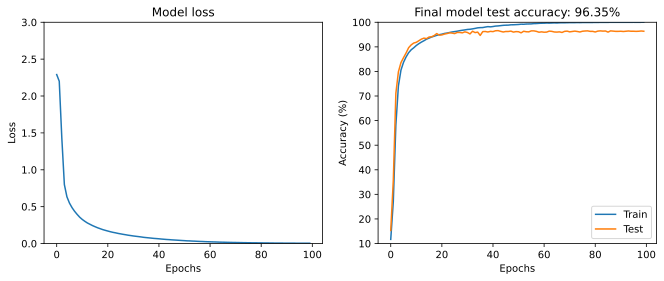

In [15]:
fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Shifted MNIST

In [ ]:
''' A key limitation of FFNs that motivates using CNNs!

- It is trivial that shifting all images (train and test) will not affect categorization performance.
- Here we will leave the training images as-is, and shift the test images by a few pixels.
'''

## Create train/test groups using DataLoader

In [16]:
data_tensor = torch.tensor(dataNorm).float()
labels_tensor = torch.tensor(labels).long()

train_data, test_data, train_labels, test_labels = train_test_split(data_tensor, labels_tensor, test_size=.1)

trainset = TensorDataset(train_data, train_labels)
testset = TensorDataset(test_data, test_labels)

batchsize=32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

## Shift the test images by a few pixels

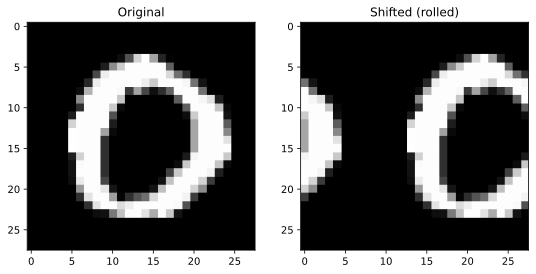

In [17]:
# first let's see how to shift a vectorized image

# grab one image data
tmp = test_loader.dataset.tensors[0][0,:]
tmp = tmp.reshape(28,28) # reshape to 2D image

# shift the image (pytorch calls it "rolling")
tmpS = torch.roll(tmp, 8, dims=1)

# now show them both
fig, ax = plt.subplots(1,2,figsize=(9,6))
ax[0].imshow(tmp, cmap='gray')
ax[0].set_title('Original')

ax[1].imshow(tmpS, cmap='gray')
ax[1].set_title('Shifted (rolled)')

plt.show()

In [18]:
# now repeat for all images in the test set

for i in range(test_loader.dataset.tensors[0].shape[0]):

    # get the image
    img = test_loader.dataset.tensors[0][i,:]

    # reshape and roll by max. 10 pixels
    randroll = np.random.randint(-10,11)
    img = torch.roll(img.reshape(28,28), randroll, dims=1)

    # re-vectorize and put back into the matrix
    test_loader.dataset.tensors[0][i,:] = img.reshape(1,-1)

# Note: now run the previous cell again to confirm the shifting

## Run the model and show the results!

In [19]:
trainAcc, testAcc, losses, net = function2trainTheModel()

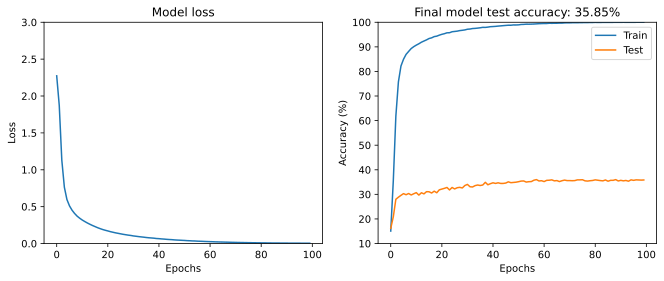

In [20]:
fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc, label='Train')
ax[1].plot(testAcc, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# The mystery of the missing 7

In [ ]:
''' How does a DL model classify things it has never seen?
'''

In [33]:
# import dataset
data = np.loadtxt(open('sample_data/mnist_train_small.csv', 'rb'), delimiter=',')

# extract labels (number IDs) and remove from data
labels = data[:,0]
data = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

## Create train/test groups using DataLoader

In [34]:
# convert to tensor
data_tensor = torch.tensor(dataNorm).float()
labels_tensor = torch.tensor(labels).long()

# boolean vector with the 7's
where7 = (labels==7)

# seperate data into tensors with, and without, 7's
dataNo7 = data_tensor[~where7, :]
labelsNo7 = labels_tensor[~where7]

data7 = data_tensor[where7, :]

# convert into PyTorch Datasets
trainset = TensorDataset(dataNo7, labelsNo7)
testset = TensorDataset(data7)

# translate into DataLoader objects
batchsize=32
train_loader = DataLoader(trainset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(testset, batch_size=testset.tensors[0].shape[0])

In [22]:
# confirm that the separation is accurate
np.unique(labelsNo7)

array([0, 1, 2, 3, 4, 5, 6, 8, 9])

## Create the DL model

In [35]:
def createTheMNISTNet():

    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            self.input = nn.Linear(784, 64)
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)
            self.output = nn.Linear(32,10)

        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return torch.log_softmax(self.output(x), axis=1)
            # NOTE: log-softmax output for later inspection!!

    net = mnistNet()

    lossfunc = nn.NLLLoss()

    optimizer = torch.optim.SGD(net.parameters(), lr=.01)

    return net, lossfunc, optimizer

## Create a function that trains the model

In [39]:
def function2trainTheModel():

    numepochs = 100

    net, lossfunc, optimizer = createTheMNISTNet()

    losses = torch.zeros(numepochs)
    trainAcc = []

    for epochi in range(numepochs):

        batchAcc = []
        batchLoss = []
        for X, y in train_loader:
            yHat = net(X)
            loss = lossfunc(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append( 100 * torch.mean((torch.argmax(yHat, axis=1)==y).float()).item() )

        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

    return trainAcc, losses, net

## Run the model and show the results!

In [40]:
trainAcc, losses, net = function2trainTheModel()

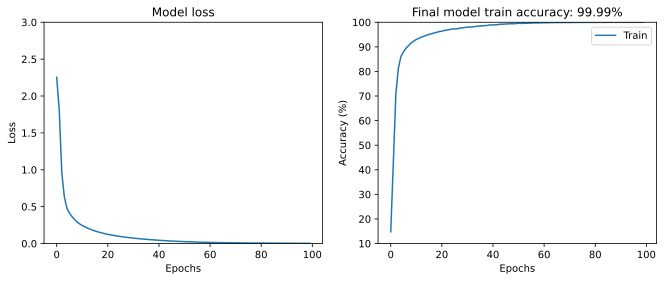

In [41]:
fig,ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model train accuracy: {trainAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

## Now for the mystery test!

In [42]:
# run the model through for the test data
X = next(iter(test_loader))[0] # note: only one output, hence the [0]

predictions = net(X).detach()

# save the model guesses
guesses = torch.argmax(predictions, axis=1).detach()

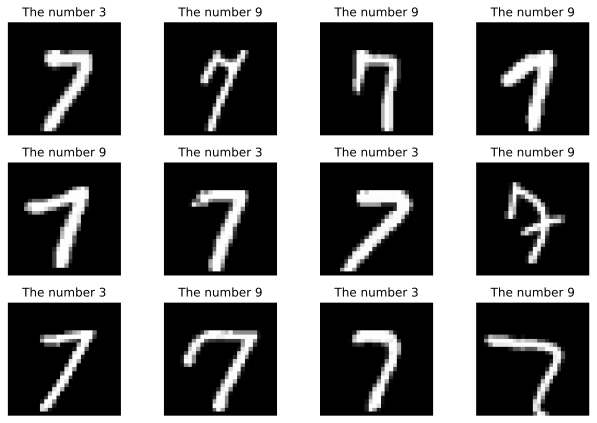

In [43]:
# show some 7's and their labels
fig, axs = plt.subplots(3,4,figsize=(9,6))

someRandom7s = np.random.choice(len(X),12)

for i, ax in enumerate(axs.flatten()):

    thisimg = X[someRandom7s[i]].view(28,28)
    ax.imshow(thisimg, cmap='gray')
    ax.set_title(f'The number {guesses[someRandom7s[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

[0 1 2 3 4 5 6 8 9]


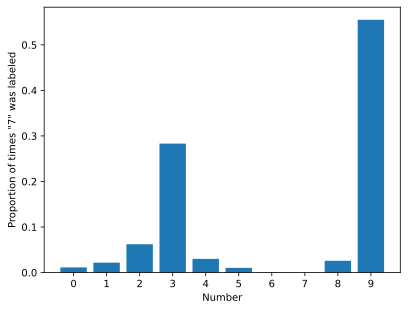

In [44]:
# which numbers are most likely to be confused with 7?
print(np.unique(guesses))

probMistaken = np.zeros(10)

for i in range(10):
    probMistaken[i] = torch.mean((guesses==i).float())

plt.bar(range(10), probMistaken)
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Proportion of times "7" was labeled')
plt.show()

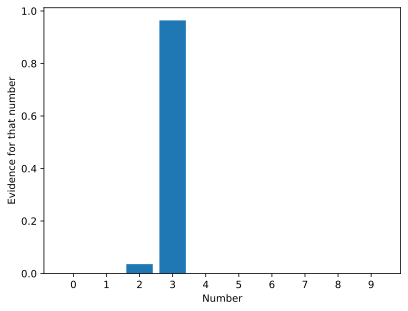

In [45]:
# Evidence for all numbers from one sample
sample2show = 30

plt.bar(range(10), torch.exp(predictions[sample2show]))
plt.xticks(range(10))
plt.xlabel('Number')
plt.ylabel('Evidence for that number')
plt.show()

# Universal approximation theorem

In [ ]:
''' UAT
- A sufficiently wide and deep network can approximate any possible function.
- A "function" is an input-output mapping, which is the entire goal of training and using FNNs.

* What does it mean?
- A DL network can solve any problem or perform any task, provided that the task can be represented as an input-output function.

* Why is this true?
- The combination of linear weighted combination and nonlinear activation function guarantees that
  any mapping from any space to any other space is, in theory, possible.

* Does it always work in practice?
- Eh, kindof. The UAT says that any function approximation is theoretically possible.
- Whether it happens in practice depends on network architecture.
- The UAT does not guarantee that any given network will solve any given problem!

* Assumptions of UAT
- The network is either shallow but arbitrarily wide, or is arbitrarily deep but narrow.

'''